<a href="https://colab.research.google.com/github/MicheleUIT/gen-ai-photography/blob/main/image_improver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed May 15 15:53:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              33W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
pip install diffusers transformers accelerate scipy safetensors accelerate

In [3]:
pip install -i https://pypi.org/simple/ bitsandbytes

Looking in indexes: https://pypi.org/simple/


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

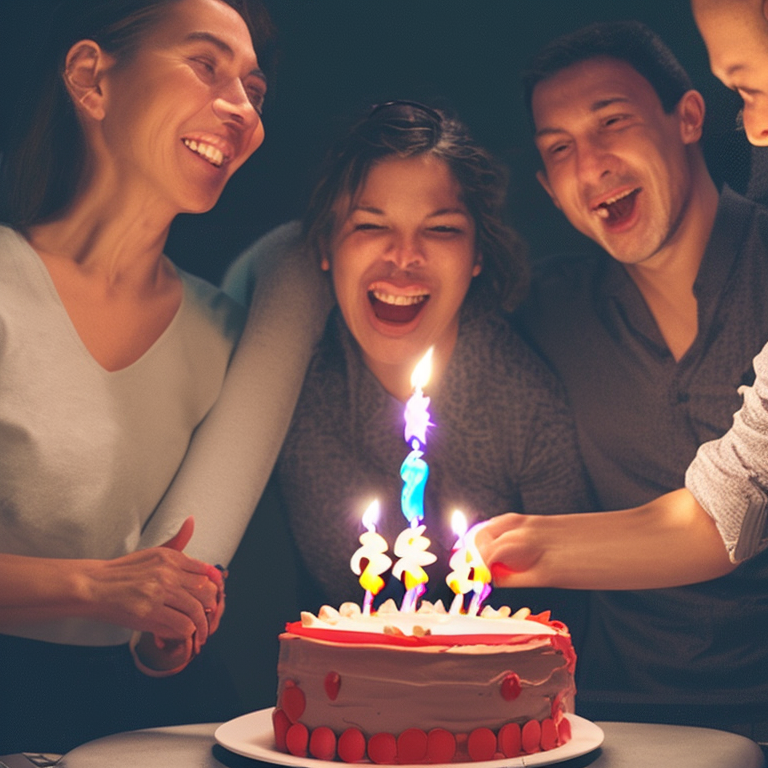

In [4]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

prompt = "3 people celebrating a birthday, one is blowing out the lights on the cake"
image = pipe(prompt).images[0]

image.save("astronaut_rides_horse.png")
image

In [ ]:
import requests
from PIL import Image

import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

model_id = "llava-hf/llava-1.5-7b-hf"
prompt_in = "Describe what could be improved in this picture as a short prompt"
prompt = "USER: <image>\n" +  prompt_in + "\nASSISTANT:"


model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    load_in_4bit=True
)

processor = AutoProcessor.from_pretrained(model_id)


raw_image = image
inputs = processor(prompt, raw_image, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
prompt_out = processor.decode(output[0][2:], skip_special_tokens=True)
print(prompt_out)
# https://huggingface.co/llava-hf/llava-1.5-7b-hf

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
/usr/local/lib/python3.10/dist-packages/transformers/models/llava/configuration_llava.py:103: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
prompt_out = prompt_out.replace("ER: ", "")
prompt_out = prompt_out.replace(prompt_in, "").strip()
prompt_out = prompt_out.replace("ASSISTANT: ", "")
print(prompt_out)

In [ ]:
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

images = pipe(prompt_out, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]
